In [18]:
import torch
import matplotlib.pyplot as plt
import botorch
from models import *

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Define the Objective Function

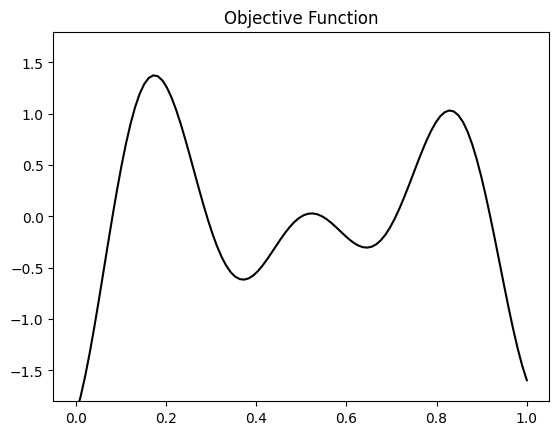

In [82]:
def objective(x):
    x = (x * 10) - 5
    return (1.4 - 3 * x) * torch.sin(1.5 * x) / 8

test_x = torch.linspace(0, 1, 100).double().unsqueeze(-1).to(device)
test_y = objective(test_x)

plt.title("Objective Function")
plt.plot(test_x.cpu(), test_y.cpu(), color="black")
plt.ylim(-1.8, 1.8)
plt.show()

## Posterior Visualizations

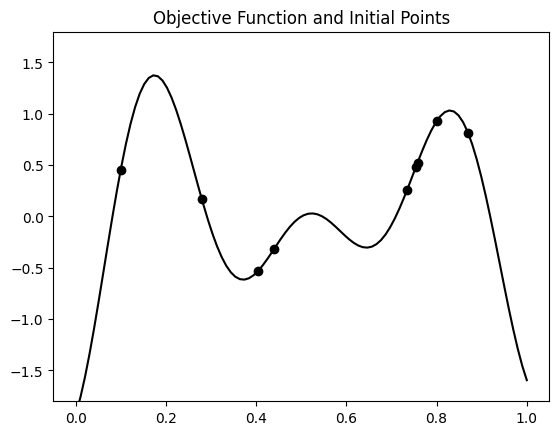

In [84]:
train_x = torch.tensor([[0.7576],
        [0.2793],
        [0.4031],
        [0.7347],
        [0.0993],
        [0.7999],
        [0.7544],
        [0.8695],
        [0.4388]]).double().to(device)
train_y = objective(train_x)

plt.title("Objective Function and Initial Points")
plt.plot(test_x.cpu(), test_y.cpu(), color="black")
plt.scatter(train_x.cpu(), train_y.cpu(), color="black")
plt.ylim(-1.8, 1.8)
plt.show()

In [12]:
def plot_posterior(train_x, train_y, posterior, model_name):
    # plot true values
    plt.plot(test_x.cpu(), test_y.cpu(), color="black", linestyle="dashed", label="True Function", linewidth=2)
    plt.scatter(train_x.cpu(), train_y.cpu(), color="black")

    # plot mean and std
    mean = posterior.mean.detach().squeeze().cpu()
    std = torch.sqrt(posterior.variance).detach().squeeze().cpu()
    plt.plot(test_x.squeeze().cpu(), mean, color="C0", label="Mean", linewidth=2)
    plt.gca().fill_between(test_x.squeeze().cpu(), mean - 2 * std, mean + 2 * std, label=r'2$\sigma$', alpha = 0.2, color="orange")

    # plot function draws
    draws = posterior.rsample(torch.Size([8])).detach().cpu().squeeze()
    for i, draw in enumerate(draws):
        if i == 0: # add one legend
            plt.plot(test_x.squeeze().cpu(), draw, color="C3", alpha=0.3, label="Function Draw")
        else:
            plt.plot(test_x.squeeze().cpu(), draw, color="C3", alpha=0.3)

    plt.ylim(-1.8, 1.8)
    plt.legend(loc="lower center")
    plt.title("%s Uncertainty" % model_name)
    plt.show()

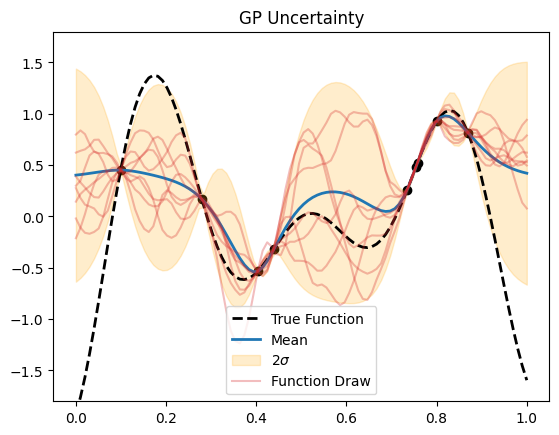

In [117]:
gp = SingleTaskGP(model_args={}, input_dim=1, output_dim=1)
gp.fit_and_save(train_x, train_y, None)
plot_posterior(train_x, train_y, gp.posterior(test_x), "GP")

Epoch 1000/1000 Pre-train loss 0.15
Epoch 1000/5000 - Loss: -1.678 noise: 1.472
Epoch 2000/5000 - Loss: -4.150 noise: 0.875
Epoch 3000/5000 - Loss: -5.054 noise: 0.136
Epoch 4000/5000 - Loss: -5.296 noise: 0.021
Epoch 5000/5000 - Loss: -5.310 noise: 0.020


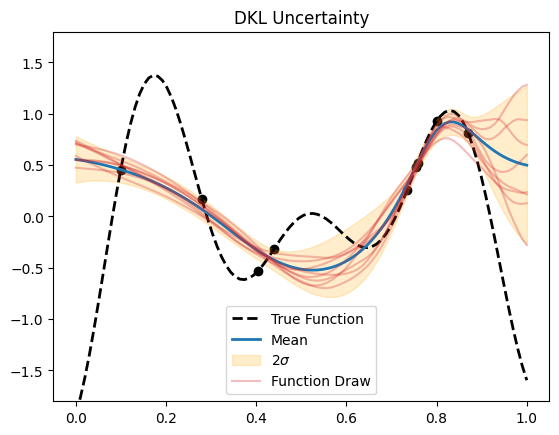

In [72]:
dkl = SingleTaskDKL({
      "regnet_dims": [128],
      "regnet_activation": "tanh",
      "pretrain_steps": 1000,
      "train_steps": 5000,
      "learning_rate": 5e-4
}, 1, 1, device)
dkl.fit_and_save(train_x, train_y, None)
plot_posterior(train_x, train_y, dkl.posterior(test_x), "DKL")

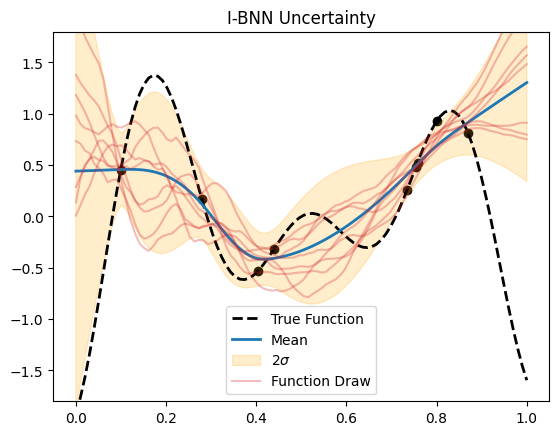

In [119]:
ibnn = SingleTaskIBNN({
      "var_b": 1.3,
      "var_w": 10,
      "depth": 3
}, 1, 1, device)
ibnn.fit_and_save(train_x, train_y, None)
plot_posterior(train_x, train_y, ibnn.posterior(test_x), "I-BNN")

1000 69159.27620774569 9.259719633757173
HMC leapfrog
	iter 0	step size 0.020000	 leapfrog steps 1
	iter 200	step size 0.001244	 leapfrog steps 17
	iter 400	step size 0.001521	 leapfrog steps 14
	final step size 0.001853	 leapfrog steps 11
	iter 600	step size 0.001853	 leapfrog steps 11
	iter 800	step size 0.001853	 leapfrog steps 11
	accept prob 0.602
1000 69158.04386972998 12.017156155137688
HMC leapfrog
	iter 0	step size 0.020000	 leapfrog steps 1
	iter 200	step size 0.003277	 leapfrog steps 7
	iter 400	step size 0.001633	 leapfrog steps 13
	final step size 0.001842	 leapfrog steps 11
	iter 600	step size 0.001842	 leapfrog steps 11
	iter 800	step size 0.001842	 leapfrog steps 11
	accept prob 0.674


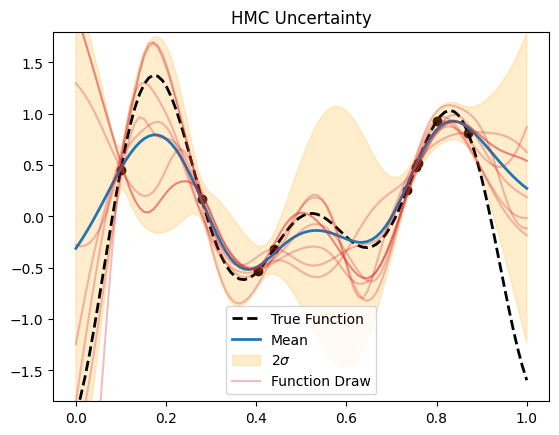

In [125]:
hmc = HMC({
      "regnet_dims": [128, 128, 128],
      "regnet_activation": "tanh",
      "n_chains": 2,
      "n_samples_per_chain": 500,
      "n_burn_in": 500,
      "noise_var": 0.1,
      "prior_var": 10.0,
      "step_size": 0.02,
      "path_length": 0.02,
      "pretrain_steps": 1000,
      "adapt_step_size": True,
      "adapt_noise": False,
      "standardize_y": False
}, input_dim=1, output_dim=1, device=device)
hmc.fit_and_save(train_x, train_y, None)
plot_posterior(train_x, train_y, hmc.posterior(test_x), "HMC")


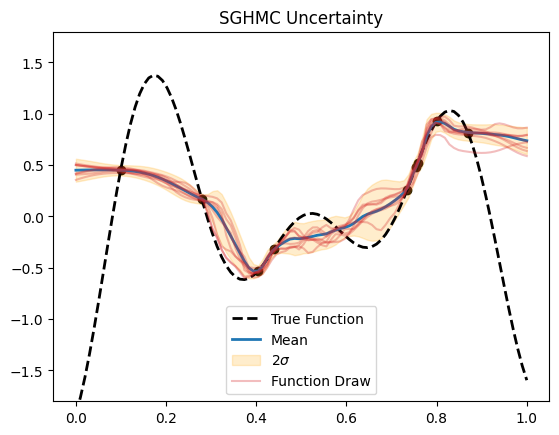

In [121]:
sghmc = SGHMCModel({
      "regnet_dims": [128, 128, 128],
      "regnet_activation": "tanh",
      "prior_var": 10.0
}, input_dim=1, output_dim=1, device=device)
sghmc.fit_and_save(train_x.to(device), train_y.to(device), None)
plot_posterior(train_x, train_y, sghmc.posterior(test_x), "SGHMC")


training 0
training 1
training 2
training 3
training 4
training 5
training 6
training 7
training 8
training 9


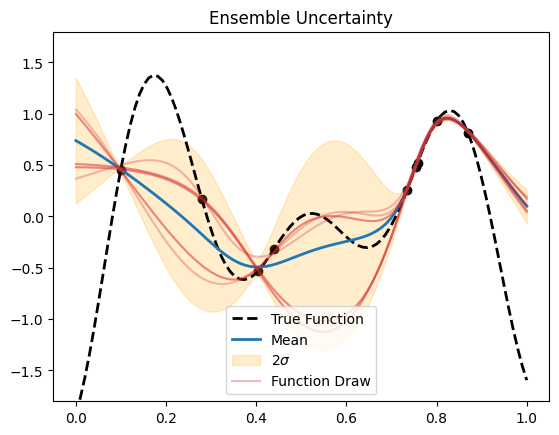

In [122]:
ensemble = Ensemble({
      "n_models": 10,
      "train_prop": 0.8,
      "regnet_dims": [128, 128, 128],
      "regnet_activation": "tanh",
      "train_steps": 1000,
      "prior_var": 10.0,
      "adapt_noise": False,
      "noise_var": 0.01
}, input_dim=1, output_dim=1, device=device)
ensemble.fit_and_save(train_x, train_y, None)
plot_posterior(train_x, train_y, ensemble.posterior(test_x), "Ensemble")


## Bayesian Optimization

In [77]:
def plot_posterior_and_acquisition(train_x, train_y, posterior, acquisition, iter):
    fig, ax1 = plt.subplots()

    # plot true values
    ax1.plot(test_x.cpu(), test_y.cpu(), color="black", linestyle="dashed", label="True Function", linewidth=2)
    ax1.scatter(train_x.cpu(), train_y.cpu(), color="black")
    ax1.set_ylim(-1.8, 1.8)

    # plot mean and std
    mean = posterior.mean.detach().squeeze().cpu()
    std = torch.sqrt(posterior.variance).detach().squeeze().cpu()
    ax1.plot(test_x.squeeze().cpu(), mean, color="C0", label="Mean", linewidth=2)
    ax1.fill_between(test_x.squeeze().cpu(), mean - 2 * std, mean + 2 * std, label=r'2$\sigma$', alpha = 0.2, color="orange")

    # plot function draws
    draws = posterior.rsample(torch.Size([8])).detach().cpu().squeeze()
    for i, draw in enumerate(draws):
        if i == 0: # add one legend
            plt.plot(test_x.squeeze().cpu(), draw, color="C3", alpha=0.2, label="Function Draw")
        else:
            plt.plot(test_x.squeeze().cpu(), draw, color="C3", alpha=0.2)

    ax1.legend(loc="lower center")
    
    # acquisition
    ax2 = ax1.twinx()  
    acq_values = acquisition(test_x.unsqueeze(1)).cpu().detach()
    ax2.plot(test_x.cpu(), acq_values, color="green", linestyle="dotted")
    ax2.set_ylabel("Acquisition", color="green")

    plt.title("Iteration %d" % (iter+1))
    plt.show()

In [78]:
def bayes_opt(model, train_x, train_y, iterations, print_every_n_steps=1):
    for i in range(iterations):
        model.fit_and_save(train_x, train_y, None)
        model_posterior = model.posterior(test_x)
        acquisition = botorch.acquisition.ExpectedImprovement(model, best_f=train_y.max())
        new_x, _ = botorch.optim.optimize_acqf(acquisition, bounds=torch.tensor([[0.], [1.]]).to(device), q=1, num_restarts=10, raw_samples=16)
        
        if i % print_every_n_steps == 0:
            plot_posterior_and_acquisition(train_x, train_y, model_posterior, acquisition, i)

        train_x = torch.cat([train_x, new_x])
        new_y = objective(new_x)
        train_y = torch.cat([train_y, new_y])


### GP Bayesian Optimization

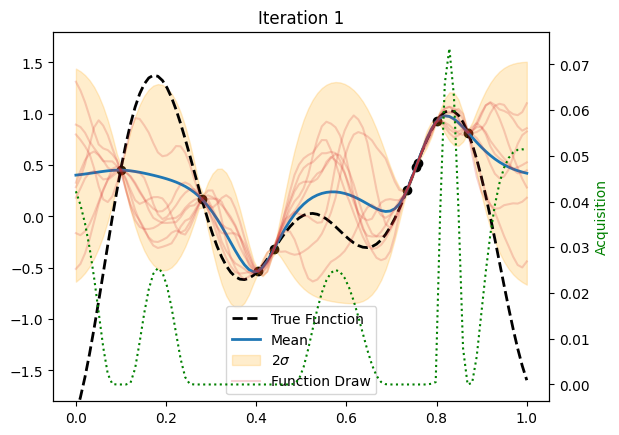

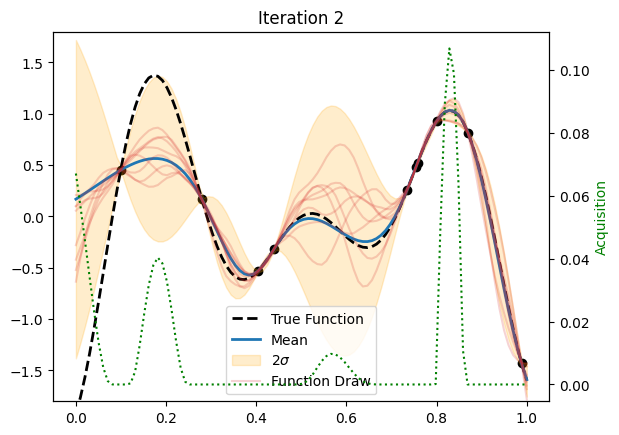

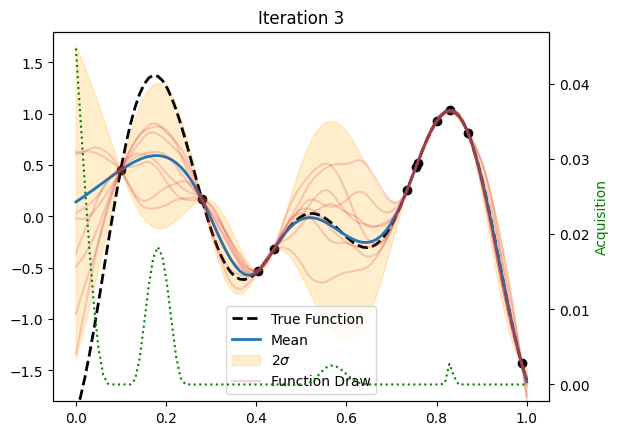

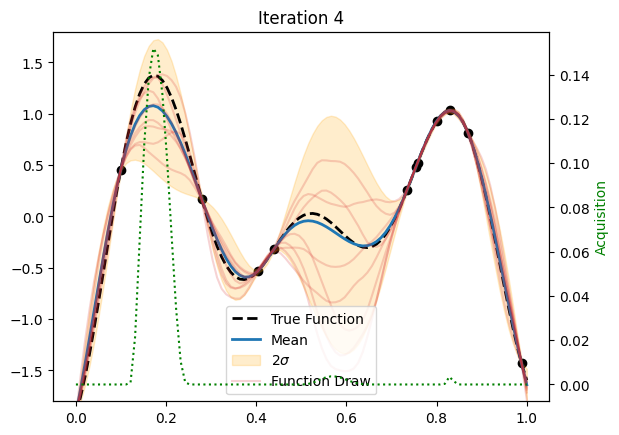

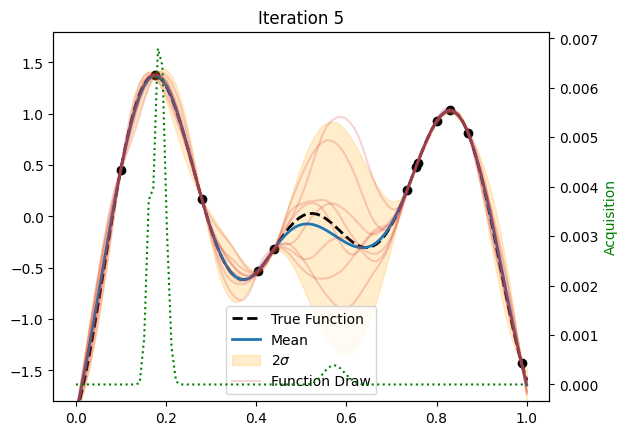

In [79]:
gp = SingleTaskGP(model_args={}, input_dim=1, output_dim=1)
bayes_opt(gp, train_x, train_y, iterations=5, print_every_n_steps=1)

### I-BNN Bayesian Optimization

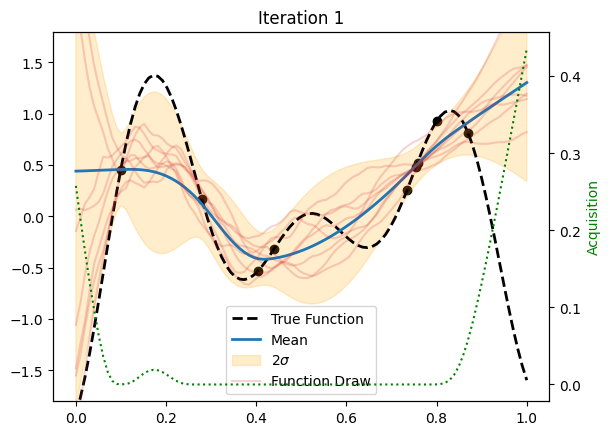

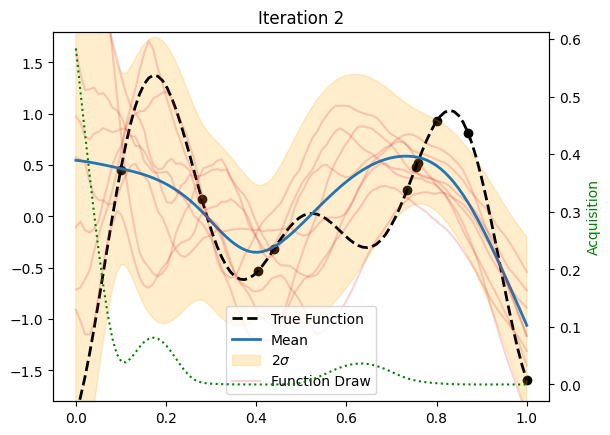

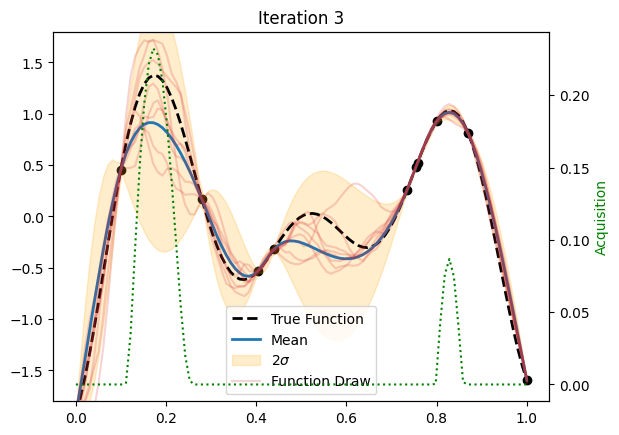

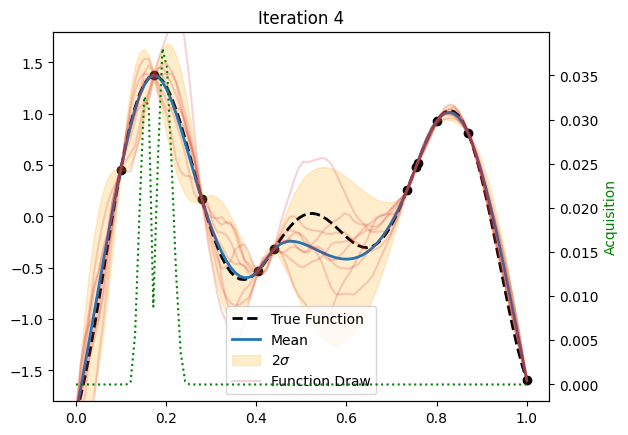

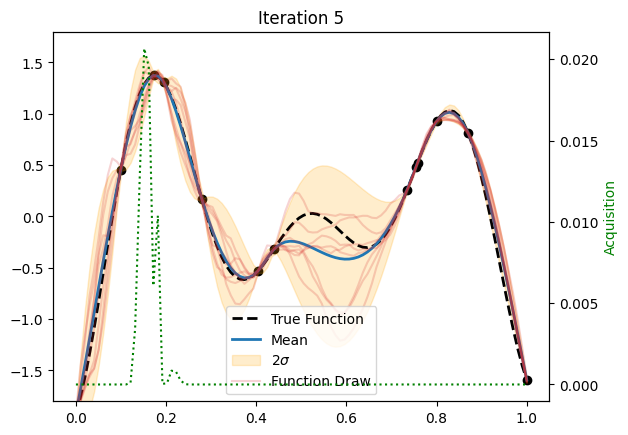

In [80]:
ibnn = SingleTaskIBNN({
      "var_b": 1.3,
      "var_w": 10,
      "depth": 3
}, 1, 1, device)
bayes_opt(ibnn, train_x, train_y, iterations=5, print_every_n_steps=1)